Changes:
- The output state now consistes of (board, falling piece, next piece) where board CONTAINS the falling piece on it
    - The game code itself keeps board and falling piece as seperate entities for easy manipulation of making the falling piece drop. However, the input to the conv net requires the falling piece to be on the board. At the end of each call of one_step, the falling piece is placed on the board, and the modified squares are kept track. This modified board with the falling piece on it is outputted as state[0]. At the beginning of the next call of one_step, the falling piece is removed from the board. The removing can be done efficiently because we have kept track of the modified squares in a global variable.
- Removed color variable of the pieces. All pieces now have color value of 1, so that the board is a binary array.
- Removed global variables movingLeft, movingRight, movingDown. Realized they are not needed.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [2]:
BOARD_WIDTH = 10
BOARD_HEIGHT = 20
BLANK = 0

TEMPLATE_WIDTH = 5
TEMPLATE_HEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

"""
Helper functions.
"""
def get_new_piece():
    """Return a random new piece.

    Returns:
       Dictionary consisting of shape, rotation, x-coordinates and y-coordinates.
    """
    shape = random.choice(list(PIECES.keys()))
    new_piece = {
        'shape': shape,
        'rotation': random.randint(0, len(PIECES[shape]) - 1),
        'x': int(BOARD_WIDTH / 2) - int(TEMPLATE_WIDTH / 2),
        'y': -2 # start it above the board (i.e. less than 0)
    }
    return new_piece

def get_blank_board():
    """Return a new blank board.

    Returns:
        Array of (BOARD_WIDTH, BOARD_HEIGHT) shape, filled with BLANK as value.
    """
    return np.full((BOARD_WIDTH, BOARD_HEIGHT), BLANK)

def is_on_board(x, y):
    """Return whether the position (x, y) is on the board.
    
    Args:
        x (int): x-coordinate
        y (int): y-coordinate

    Returns:
        Boolean value. True if (x, y) is on the board. False otherwise.
    """
    return x >= 0 and x < BOARD_WIDTH and y < BOARD_HEIGHT

"""
Tetris Environment Wrapper Class.
"""
class Env:
    def __init__(self):
        self.modified_squares = []
        self.board = get_blank_board()
        self.falling_piece = get_new_piece()
        self.next_piece = get_new_piece()

    def one_step(self, action):
        """Update environment after a step of action.
    
        Args:
            action (char): character that represents action. One of ['L', 'R', 'D', 'W', 'Q', 'S'].

        Returns:
            Tuple containing (state, reward, end_of_game).
            
            state (tuple): tuple that contains state of the game environment. (board, falling_piece, and next_piece).
            reward (int): reward per action
            end_of_game (boolean): boolean value. True if the game has ended. False otherwise.
        """
        state = (self.board, self.falling_piece, self.next_piece)
        
        # if there exists squares modified on previous step, undo the modification first before proceeding
        if self.modified_squares:
            for square in self.modified_squares:
                self.board[square[0]][square[1]] = 0
            self.modified_squares = []
        
        if not self.is_valid_position(0, 0):
            # game is finished. Return
            return (state, 0, True)

        # move the piece with the left key
        if action == 'L' and self.is_valid_position(-1, 0):
            self.falling_piece['x'] -= 1
        # move the piece with the right key
        elif action == 'R' and self.is_valid_position(1, 0):
            self.falling_piece['x'] += 1
        # rotating the piece if there is room to rotate
        elif action == 'W':
            self.falling_piece['rotation'] = (self.falling_piece['rotation'] + 1) % len(PIECES[self.falling_piece['shape']])
            if not self.is_valid_position(0, 0):
                self.falling_piece['rotation'] = (self.falling_piece['rotation'] - 1) % len(PIECES[self.falling_piece['shape']])
        # rotate the other direction
        elif action == 'Q':
            self.falling_piece['rotation'] = (self.falling_piece['rotation'] - 1) % len(PIECES[self.falling_piece['shape']])
            if not self.is_valid_position(0, 0):
                self.falling_piece['rotation'] = (self.falling_piece['rotation'] + 1) % len(PIECES[self.falling_piece['shape']])
        # make the piece fall faster with the down key
        elif action == 'D' and self.is_valid_position(0, 1):
            self.falling_piece['y'] += 1
        # move the current piece all the way down
        elif action == 'S':
            for i in range(1, BOARD_HEIGHT):
                if not self.is_valid_position(0, i):
                    break
            self.falling_piece['y'] += i - 1
        
        # if falling piece has landed, set it on the board
        if not self.is_valid_position(0, 1):
            self.add_to_board(self.falling_piece)
            reward = self.remove_complete_lines()
            self.falling_piece = self.next_piece
            self.next_piece = get_new_piece()
        # if falling piece has not landed, just move the piece down
        else:
            self.falling_piece['y'] += 1
            reward = 0
            # Add the falling piece to the board to output an image of the current state of board
            # Need to remove this falling piece from the board before the next iteration
            self.add_to_board_in_bound_modified_squares(self.falling_piece)
       
        new_state = (self.board, self.falling_piece, self.next_piece)
        return (new_state, reward, False)

    def add_to_board(self, piece):
        """Fill in the board based on piece's location, shape, and rotation.
    
        Args:
            piece (dict): data structure of a piece consisting of shape, rotation, x-coordinates and y-coordinates.

        Returns:
            None
        """
        for x in range(TEMPLATE_WIDTH):
            for y in range(TEMPLATE_HEIGHT):
                if PIECES[piece['shape']][piece['rotation']][y][x] != '.':
                    self.board[x + piece['x']][y + piece['y']] = 1
    
    def add_to_board_in_bound_modified_squares(self, piece):
        """Fill in the board based on piece's location, shape, and rotation.
        Also populates self.modified_squares with the squares on the board that were just modified
        when adding the piece to the board.
    
        Args:
            piece (dict): data structure of a piece consisting of shape, rotation, x-coordinates and y-coordinates.

        Returns:
            None
        """
        for x in range(TEMPLATE_WIDTH):
            for y in range(TEMPLATE_HEIGHT):
                if PIECES[piece['shape']][piece['rotation']][y][x] != '.' and y + piece['y'] >= 0:
                    self.board[x + piece['x']][y + piece['y']] = 1
                    self.modified_squares.append([x + piece['x'], y + piece['y']])

    def is_valid_position(self, adjX, adjY):
        """Return whether the falling piece is within the board and not colliding,
        after adding (adjX, adjY) to the current coordinates (x, y) of the falling piece.
    
        Args:
            adjX (int): move x-coordinate by adjX
            adjY (int): move y-coordinate by adjY

        Returns:
            Boolean value. True if the resulting coordinate is in valid position. False otherwise.
        """
        for x in range(TEMPLATE_WIDTH):
            for y in range(TEMPLATE_HEIGHT):
                is_above_board = y + self.falling_piece['y'] + adjY < 0
                if is_above_board or PIECES[self.falling_piece['shape']][self.falling_piece['rotation']][y][x] == '.':
                    continue
                if not is_on_board(x + self.falling_piece['x'] + adjX, y + self.falling_piece['y'] + adjY):
                    return False
                if self.board[x + self.falling_piece['x'] + adjX][y + self.falling_piece['y'] + adjY] != BLANK:
                    return False
        return True

    def is_complete_line(self, y):
        """Return whether the line in y-coordinate is completely filled with boxes.
    
        Args:
            y (int): y-coordinate

        Returns:
            Boolean value. True if the line is filled with boxes. False otherwise.
        """
        return all ([self.board[x][y] != BLANK for x in range(BOARD_WIDTH)])

    def remove_complete_lines(self):
        """Return the number of complete lines after removing any completed lines
        on the board and moving everything above them down.
    
        Returns:
            Int value. Number of lines removed.
        """
        num_lines_removed = 0
        y = BOARD_HEIGHT - 1 # start y at the bottom of the board
        while y >= 0:
            if self.is_complete_line(y):
                # Remove the line and pull boxes down by one line.
                for pull_down_Y in range(y, 0, -1):
                    for x in range(BOARD_WIDTH):
                        self.board[x][pull_down_Y] = self.board[x][pull_down_Y-1]
                # Set very top line to blank.
                for x in range(BOARD_WIDTH):
                    self.board[x][0] = BLANK
                num_lines_removed += 1
                # Note on the next iteration of the loop, y is the same.
                # This is so that if the line that was pulled down is also
                # complete, it will be removed.
            else:
                y -= 1 # move on to check next row up
        return num_lines_removed

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


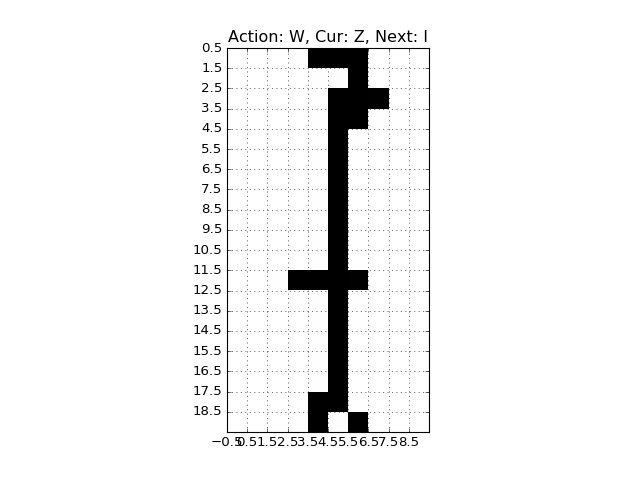

In [3]:
def animate(env, actions):
    %matplotlib
    
    fig = plt.gcf()
    fig.show()
    fig.canvas.draw()
    plt.grid()
    
    for action in actions:
        time.sleep(0.2)
        
        state, reward, done = env.one_step(action)
        if done:
            break
        falling_piece_shape = state[1]['shape']
        next_piece_shape = state[2]['shape']
        
        plt.title('Action: ' + action + ', Cur: ' + falling_piece_shape + ', Next: ' + next_piece_shape)
        
        board = state[0]

        plt.imshow(np.transpose(board), cmap=plt.cm.binary, interpolation='none')
        width = len(board)
        height = len(board[0])
        plt.xlim(-0.5, width-0.5)
        plt.ylim(height-0.5, 0.5)
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, width-0.5, 1))
        ax.set_yticks(np.arange(0.5, height-0.5, 1))
        
        fig.canvas.draw()

if __name__ == "__main__":
    random.seed(2)
    env = Env()
    possible_actions = ['L', 'R', 'D', 'W', 'Q', 'S']
    action_length = 100
    actions = [possible_actions[random.randint(0, len(possible_actions)-1)] for _ in range(action_length)]

    animate(env, actions)
    
    plt.show()